<a href="https://colab.research.google.com/github/hkoenicke/UCDPA_HeikeKoenicke/blob/main/WeatherData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import packages

import requests
from bs4 import BeautifulSoup
import re
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import fnmatch
import os.path

# Data Analysis
import pandas as pd
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path_dwd = 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/'
url_weather_stations = path_dwd + 'historical/KL_Tageswerte_Beschreibung_Stationen.txt'



In [4]:
# read information about weather stations from the website into a pandas data frame
df_weather_stations = pd.DataFrame()
df_weather_stations = pd.read_fwf(url_weather_stations,
                               encoding='ISO-8859-1',
                               header=None,
                               skiprows=[0, 1],
                               names=['Station ID', 'First Date', 'Last Date',
                                   'Altitude', 'Latitude', 'Longitude',
                                   'Station Name', 'Federal State'])

df_weather_stations.head()

,Station ID,First Date,Last Date,Altitude,Latitude,Longitude,Station Name,Federal State
0,1,19370101,19860630,478,47.8413,8.8493,Aach,Baden-Württemberg
1,3,18910101,20110331,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
2,11,19800901,20200930,680,47.9736,8.5205,Donaueschingen (Landeplatz),Baden-Württemberg
3,44,19690101,20230816,44,52.9336,8.2370,Großenkneten,Niedersachsen
4,52,19690101,20011231,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein


In [5]:
# Get list of all zip files for historic data

page_info = requests.get(path_dwd +'historical').text

# read file names using regular expression
files = re.findall(r"(?<=href=\")tageswerte_KL_[0-9]+_[0-9]+_\w*\.zip",page_info)

# get station ids using regular expression
station_ids = re.findall(r"(?<=href=\"tageswerte_KL_)[0-9]+",page_info)
# convert to int
station_ids = [int(x) for x in station_ids]

# convert the two lists into a dictionary
station_file_names = {}
station_file_names = {station_ids[i]: files[i] for i in range(len(station_ids))}

print(station_file_names)

{1: 'tageswerte_KL_00001_19370101_19860630_hist.zip', 3: 'tageswerte_KL_00003_18910101_20110331_hist.zip', 11: 'tageswerte_KL_00011_19800901_20200930_hist.zip', 44: 'tageswerte_KL_00044_19690101_20221231_hist.zip', 52: 'tageswerte_KL_00052_19690101_20011231_hist.zip', 61: 'tageswerte_KL_00061_19750701_19780831_hist.zip', 70: 'tageswerte_KL_00070_19730601_19860930_hist.zip', 71: 'tageswerte_KL_00071_19861101_20191231_hist.zip', 72: 'tageswerte_KL_00072_19780901_19950531_hist.zip', 73: 'tageswerte_KL_00073_19590301_20221231_hist.zip', 78: 'tageswerte_KL_00078_19610101_20221231_hist.zip', 90: 'tageswerte_KL_00090_19880219_20221231_hist.zip', 91: 'tageswerte_KL_00091_19781101_20221231_hist.zip', 93: 'tageswerte_KL_00093_19771201_19781031_hist.zip', 96: 'tageswerte_KL_00096_20190409_20221231_hist.zip', 98: 'tageswerte_KL_00098_18870215_19541231_hist.zip', 102: 'tageswerte_KL_00102_19980101_20221231_hist.zip', 116: 'tageswerte_KL_00116_18990601_19730531_hist.zip', 125: 'tageswerte_KL_00125_1

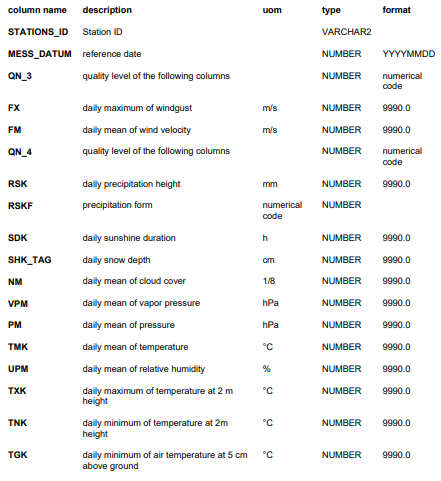

In [5]:
# Process zip files

# create data list for climate data
weather_list =  []
for id in station_ids:
  for category in ['historical','recent']:
    if category == 'historical':
      url = path_dwd + 'historical/' + station_file_names[id]
    else:
      url = path_dwd + 'recent/tageswerte_KL_' + str(id).zfill(5) + '_akt.zip'

    try:
      # open zip file
      zf = ZipFile(BytesIO(urlopen(url).read()))

      # find csv file starting with 'produkt'
      csv_file_name = fnmatch.filter(zf.namelist(),'produkt*.txt')

      # open zipped csv file
      file_csv = zf.open(*csv_file_name)

      # read specific columns and append it to the weather list
      weather_list.append(pd.read_csv(file_csv,sep=';',usecols=['STATIONS_ID',
                                                                'MESS_DATUM',
                                                                '  FX',
                                                                '  FM',
                                                                ' RSK',
                                                                'RSKF',
                                                                ' SDK',
                                                                'SHK_TAG',
                                                                '  NM',
                                                                ' TMK',
                                                                ' UPM',
                                                                ' TXK',
                                                                ' TNK',
                                                                ' TGK',
                                                                'QN_3',
                                                                'QN_4'],
                                      parse_dates=['MESS_DATUM']))

      # close txt.file and zip file
      file_csv.close()
      zf.close()

    except IOError: # ignore
      pass

# create pandas data frame with weather list
weather = pd.concat(weather_list)
# rename columns
weather = weather.rename(columns={'STATIONS_ID': 'Station ID',
                                  'MESS_DATUM': 'Date',
                                  '  FX': 'Wind_gust_max',
                                  '  FM': 'Wind_speed',
                                  ' RSK': 'Precipitation',
                                  'RSKF': 'Precipitation_form',
                                  ' SDK': 'Sunshine',
                                  'SHK_TAG': 'Snow',
                                  '  NM': 'Clouds',
                                  ' TMK': 'Temperature',
                                  ' UPM': 'Humidity',
                                  ' TXK': 'Max_temp',
                                  ' TNK': 'Min_temp',
                                  ' TGK': 'Min_temp_ground',})
# replace missing values
weather = (weather.replace(-999.0,np.nan))

In [6]:
weather.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 17910093 entries, 0 to 7364
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Station             int64         
 1   Date                datetime64[ns]
 2   QN_3                float64       
 3   Wind_gust_max       float64       
 4   Wind_speed          float64       
 5   QN_4                float64       
 6   Precipitation       float64       
 7   Precipitation_form  float64       
 8   Sunshine            float64       
 9   Snow                float64       
 10  Clouds              float64       
 11  Temperature         float64       
 12  Humidity            float64       
 13  Max_temp            float64       
 14  Min_temp            float64       
 15  Min_temp_ground     float64       
dtypes: datetime64[ns](1), float64(14), int64(1)
memory usage: 2.3 GB


In [7]:
# save in csv file
weather.to_csv('./climate_data.csv.gz', index=False, compression='gzip')

# download to local drive
from google.colab import files
files.download("climate_data.csv.gz")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
weather.info()
weather.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17910093 entries, 0 to 7364
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Station             int64         
 1   Date                datetime64[ns]
 2   QN_3                float64       
 3   Wind_gust_max       float64       
 4   Wind_speed          float64       
 5   QN_4                float64       
 6   Precipitation       float64       
 7   Precipitation_form  float64       
 8   Sunshine            float64       
 9   Snow                float64       
 10  Clouds              float64       
 11  Temperature         float64       
 12  Humidity            float64       
 13  Max_temp            float64       
 14  Min_temp            float64       
 15  Min_temp_ground     float64       
dtypes: datetime64[ns](1), float64(14), int64(1)
memory usage: 2.3 GB


,Station,QN_3,Wind_gust_max,Wind_speed,QN_4,Precipitation,Precipitation_form,Sunshine,Snow,Clouds,Temperature,Humidity,Max_temp,Min_temp,Min_temp_ground
count,1.791009e+07,5.250438e+06,4.821853e+06,5.128318e+06,1.671785e+07,1.635713e+07,1.630548e+07,8.001115e+06,1.460077e+07,1.421838e+07,1.662726e+07,1.595120e+07,1.632795e+07,1.632766e+07,1.367523e+07
mean,3.328422e+03,8.341795e+00,1.065256e+01,3.679027e+00,6.535743e+00,2.197533e+00,2.375860e+00,4.485629e+00,2.355336e+00,5.352033e+00,8.669860e+00,7.897881e+01,1.294061e+01,4.634678e+00,3.330440e+00
std,2.690956e+03,2.605082e+00,4.826327e+00,2.388846e+00,3.187962e+00,4.876527e+00,2.841201e+00,4.284912e+00,1.558526e+01,2.389017e+00,7.518564e+00,1.200105e+01,8.790770e+00,6.805426e+00,6.801924e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.310000e+01,2.000000e+00,-3.150000e+01,-3.630000e+01,-3.910000e+01
25%,1.447000e+03,5.000000e+00,7.200000e+00,2.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,3.000000e-01,0.000000e+00,3.700000e+00,3.100000e+00,7.100000e+01,6.100000e+00,0.000000e+00,-1.100000e+00
50%,3.031000e+03,1.000000e+01,9.800000e+00,3.100000e+00,5.000000e+00,0.000000e+00,1.000000e+00,3.500000e+00,0.000000e+00,6.000000e+00,8.800000e+00,8.100000e+01,1.300000e+01,4.900000e+00,3.500000e+00
75%,4.625000e+03,1.000000e+01,1.300000e+01,4.700000e+00,1.000000e+01,2.200000e+00,6.000000e+00,7.700000e+00,0.000000e+00,7.400000e+00,1.460000e+01,8.800000e+01,1.970000e+01,1.000000e+01,8.500000e+00
max,1.963100e+04,1.000000e+01,9.300000e+01,3.490000e+01,1.000000e+01,3.120000e+02,8.000000e+00,1.900000e+01,7.800000e+02,1.000000e+01,3.240000e+01,1.010000e+02,4.120000e+01,2.620000e+01,2.540000e+01


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['Station'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['QN_3'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_2, *['Wind_gust_max'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_3, *['Wind_speed'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_4, *['Station'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_5, *['QN_3'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_6, *['Wind_gust_max'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_7, *['Wind_speed'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 10 * figscale, 10 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_8, *[[['Station', 'QN_3'], ['QN_3', 'Wind_gust_max'], ['Wind_gust_max', 'Wind_speed'], ['Wind_speed', 'QN_4']]], **{})
chart

In [10]:
weather.head()

,Station,Date,QN_3,Wind_gust_max,Wind_speed,QN_4,Precipitation,Precipitation_form,Sunshine,Snow,Clouds,Temperature,Humidity,Max_temp,Min_temp,Min_temp_ground
0,1,1937-01-01,NaN,NaN,NaN,5.0,0.0,0.0,NaN,0.0,6.3,-0.5,NaN,2.5,-1.6,NaN
1,1,1937-01-02,NaN,NaN,NaN,5.0,0.0,0.0,NaN,0.0,3.0,0.3,NaN,5.0,-4.0,NaN
2,1,1937-01-03,NaN,NaN,NaN,5.0,0.0,0.0,NaN,0.0,4.3,3.2,NaN,5.0,-0.2,NaN
3,1,1937-01-04,NaN,NaN,NaN,5.0,0.0,0.0,NaN,0.0,8.0,0.2,NaN,3.8,-0.2,NaN
4,1,1937-01-05,NaN,NaN,NaN,5.0,0.0,0.0,NaN,0.0,8.0,1.4,NaN,4.5,-0.7,NaN


In [ ]:
# upload file
from google.colab import files
uploaded = files.upload()

In [12]:
# read data into a pandas data frame
df_climate = pd.read_csv(r"./climate_data.csv.gz")

In [8]:
df_climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17910093 entries, 0 to 17910092
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Station             int64  
 1   Date                object 
 2   QN_3                float64
 3   Wind_gust_max       float64
 4   Wind_speed          float64
 5   QN_4                float64
 6   Precipitation       float64
 7   Precipitation_form  float64
 8   Sunshine            float64
 9   Snow                float64
 10  Clouds              float64
 11  Temperature         float64
 12  Humidity            float64
 13  Max_temp            float64
 14  Min_temp            float64
 15  Min_temp_ground     float64
dtypes: float64(14), int64(1), object(1)
memory usage: 2.1+ GB


In [11]:
# calculate from/to date for each station
station_dates = df_climate.groupby('Station')['Date'].aggregate(['min','max'])
print(station_dates)

NameError: ignored

In [10]:
df = pd.merge(df_weather_stations,station_dates,on='Station ID', how='outer')

KeyError: ignored

In [19]:
df_weather_stations.info()
station_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Station ID     1351 non-null   int64  
 1   First Date     1351 non-null   int64  
 2   Last Date      1351 non-null   int64  
 3   Altitude       1351 non-null   int64  
 4   Latitude       1351 non-null   float64
 5   Longitude      1351 non-null   float64
 6   Station Name   1351 non-null   object 
 7   Federal State  1351 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 84.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1250 entries, 1 to 19631
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   min     1250 non-null   object
 1   max     1250 non-null   object
dtypes: object(2)
memory usage: 29.3+ KB
